In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
%matplotlib notebook
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None


In [2]:
NUM_MELHORES = 40

In [3]:
df_melhores = pd.read_feather('dados/melhores.feather')
df_turmas = pd.read_feather('dados/turmas2018.feather')
df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')

In [4]:
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')

## Nota final
Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas. 

Algumas universidades consideram um peso distinto de acordo com a disciplina

### Pesos UFRJ

Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

- Redação: peso 3 (mínimo 300)
- Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
    - Matemática tem peso 4
- Ciências Econômicas, Geologia e Meteorologia
    - Matemática peso 3
- Engenharias e Química Industrial
    - Ciências da Natureza: peso 4
- Geologia
    - Ciências da Natureza: peso 3
- Humanas
    - Ciências Humanas e Linguagens: peso 2



In [5]:
notas_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', ]
notas_pesos =(1, 1, 1, 1, 4)


In [6]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

df_enem_rio['nota_final'] = df_enem_rio\
  .loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols ]\
  .apply(media_ponderada, axis=1).round(0)
df_enem_rio[notas_cols+ ['nota_final']].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,468.7,563.8,508.3,513.7,340.0,427.0
1,592.8,706.0,633.1,740.3,820.0,744.0
2,431.7,560.9,479.7,557.0,560.0,534.0
3,590.7,487.7,527.6,492.7,600.0,562.0
4,530.7,669.8,626.8,638.1,740.0,678.0


In [7]:
notas_agg = {col: (col, 'median') for col in notas_cols}
notas_agg['mediana'] = ('nota_final', 'median')
notas_agg['num'] = ('nota_final', 'count')

df_melhores = df_enem_rio.groupby('CO_ESCOLA')\
       .agg(**notas_agg).sort_values('mediana', ascending=False)
df_melhores = df_melhores[df_melhores.num > 30] #corte arbitrário, só quem tem mais de 30 alunos
df_melhores.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33135371,662.7,691.40,635.00,763.2,920.0,803.0,91
33062633,689.5,702.85,645.70,801.1,900.0,800.5,62
33063729,653.3,692.05,628.35,766.7,900.0,789.0,245
33176825,654.4,691.10,637.60,771.8,900.0,788.0,185
33148376,615.2,679.80,617.75,747.7,900.0,780.0,73


In [8]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837

In [9]:
df_melhores['CO_ESCOLA'] = df_melhores.index.astype('category')
df_melhores['rank'] = df_melhores.mediana.rank(ascending=False, method='min')

In [10]:
df_melhores = df_melhores.merge(df_escolas, left_index=True, right_on='CO_ENTIDADE').loc[:,
    ['NO_ENTIDADE',  'mediana', 'num', 'rank'] + notas_cols + ['CO_ENTIDADE']]
df_melhores

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,1.0,662.70,691.40,635.00,763.20,920.0,33135371
177267,COL DE SAO BENTO,800.5,62,2.0,689.50,702.85,645.70,801.10,900.0,33062633
177286,COLEGIO SANTO INACIO,789.0,245,3.0,653.30,692.05,628.35,766.70,900.0,33063729
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,788.0,185,4.0,654.40,691.10,637.60,771.80,900.0,33176825
188313,ESCOLA PARQUE - BARRA,780.0,73,5.0,615.20,679.80,617.75,747.70,900.0,33148376
...,...,...,...,...,...,...,...,...,...,...
188256,CE COMPOSITOR MANACEIA JOSE DE ANDRADE,455.0,35,262.0,458.00,552.60,502.60,444.00,410.0,33132887
189760,CE HERBERT DE SOUZA,454.0,46,263.0,462.30,524.40,480.60,471.50,400.0,33126224
189279,CE PROFESSOR JOSE DE SOUZA MARQUES,439.0,63,264.0,447.20,556.20,527.50,499.00,360.0,33135193
189673,CIEP 303 AYRTON SENNA DA SILVA,439.0,77,264.0,453.30,556.40,506.00,502.40,380.0,33105103


In [89]:

df_enem = df_melhores[['CO_ENTIDADE']].merge(df_enem_rio, 
                     left_on='CO_ENTIDADE', right_on='CO_ESCOLA')\
          .loc[:,list(notas_cols) + ['CO_ESCOLA', 'nota_final']]
df_enem.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ESCOLA,nota_final
0,696.6,721.4,680.7,766.3,940.0,33135371,828.0
1,684.8,723.6,670.2,783.1,940.0,33135371,828.0
2,724.9,709.5,653.4,872.0,940.0,33135371,840.0
3,658.4,686.2,623.1,747.0,920.0,33135371,799.0
4,601.7,659.8,591.8,754.0,920.0,33135371,786.0


In [90]:
my_order = df_melhores.head(NUM_MELHORES).NO_ENTIDADE

Ajustar no gráfico abaixo:

- diminuir nomes de escola muito grandes


In [91]:
df_melhores['rotulo'] = df_melhores.loc[:,['NO_ENTIDADE', 'num', 'rank']].apply(lambda x: '{:>s} {:03d}/{:>2.0f}'.format(x[0].title(), x[1], x[2]), axis=1)

In [88]:
df_melhores

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE,rotulo
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,1.0,662.70,691.40,635.00,763.20,920.0,33135371,Colegio Cruzeiro - Jacarepagua 091/ 1
177267,COL DE SAO BENTO,800.5,62,2.0,689.50,702.85,645.70,801.10,900.0,33062633,Col De Sao Bento 062/ 2
177286,COLEGIO SANTO INACIO,789.0,245,3.0,653.30,692.05,628.35,766.70,900.0,33063729,Colegio Santo Inacio 245/ 3
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,788.0,185,4.0,654.40,691.10,637.60,771.80,900.0,33176825,Colegio Santo Agostinho - Unidade Instituto Cu...
188313,ESCOLA PARQUE - BARRA,780.0,73,5.0,615.20,679.80,617.75,747.70,900.0,33148376,Escola Parque - Barra 073/ 5
...,...,...,...,...,...,...,...,...,...,...,...
188256,CE COMPOSITOR MANACEIA JOSE DE ANDRADE,455.0,35,262.0,458.00,552.60,502.60,444.00,410.0,33132887,Ce Compositor Manaceia Jose De Andrade 035/262
189760,CE HERBERT DE SOUZA,454.0,46,263.0,462.30,524.40,480.60,471.50,400.0,33126224,Ce Herbert De Souza 046/263
189279,CE PROFESSOR JOSE DE SOUZA MARQUES,439.0,63,264.0,447.20,556.20,527.50,499.00,360.0,33135193,Ce Professor Jose De Souza Marques 063/264
189673,CIEP 303 AYRTON SENNA DA SILVA,439.0,77,264.0,453.30,556.40,506.00,502.40,380.0,33105103,Ciep 303 Ayrton Senna Da Silva 077/264


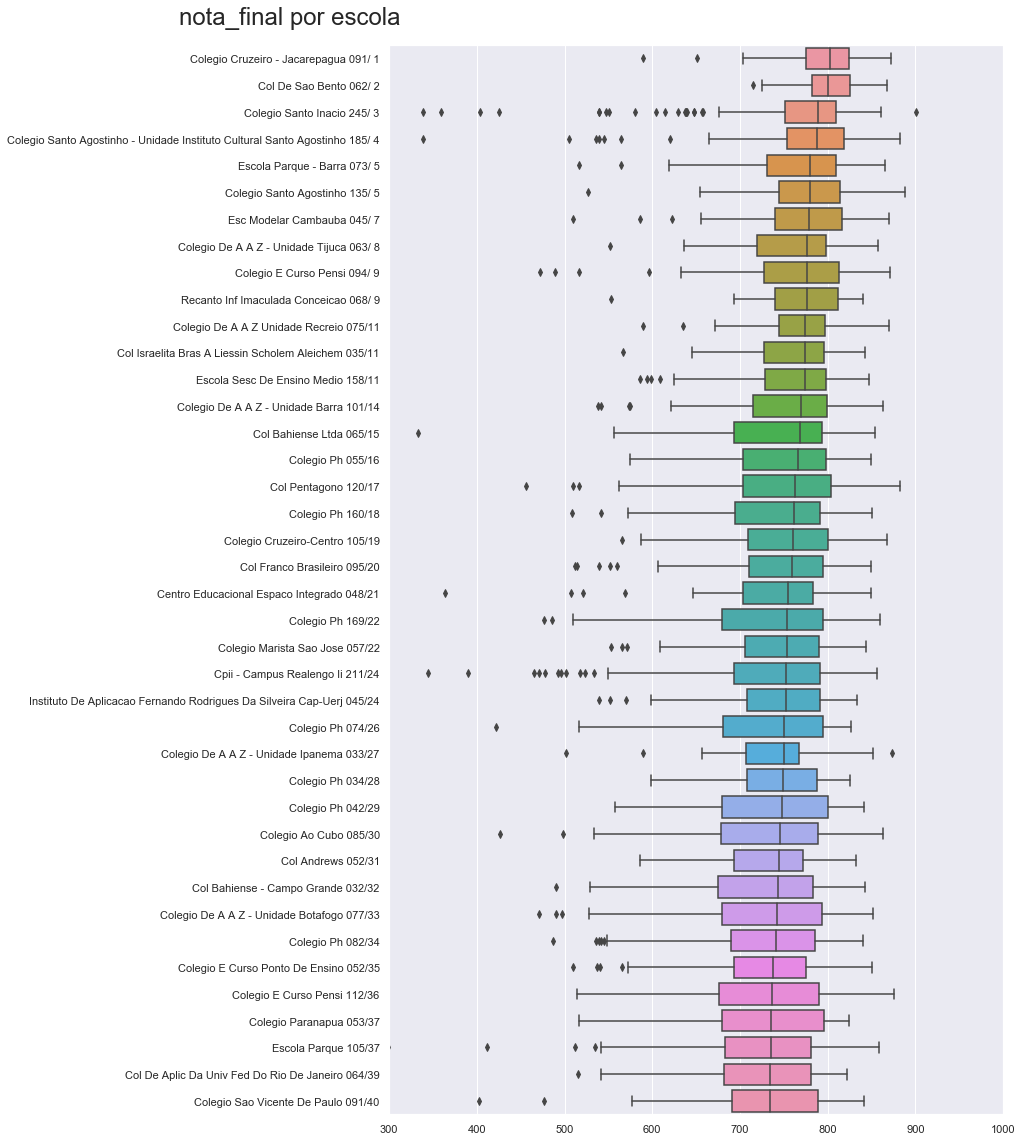

In [105]:


def compara_distribuicoes(nota):
    sns.set(rc={'figure.figsize':(11,18), 'axes.xmargin': .1})
    #sns.palplot(sns.hls_palette(8, l=.3, s=.8))
    
    nota_agrupada = nota
    if nota=='nota_final':
        nota_agrupada = 'mediana'
    
    df_top = df_melhores.sort_values(nota_agrupada, ascending=False).head(NUM_MELHORES)
    ax = sns.boxplot(data=df_enem, y='CO_ESCOLA', x=nota, orient='h'
                     ,order=df_top.CO_ENTIDADE)
    ax.set(ylabel='', xlabel='')
    plt.gcf().subplots_adjust(top=.95)
    plt.suptitle(f'{nota} por escola',x=0, size=24, );
    locs, _ = plt.yticks()
    plt.yticks(locs, df_top.rotulo);
    ax.set_xlim(300, 1000)
    

compara_distribuicoes('nota_final');


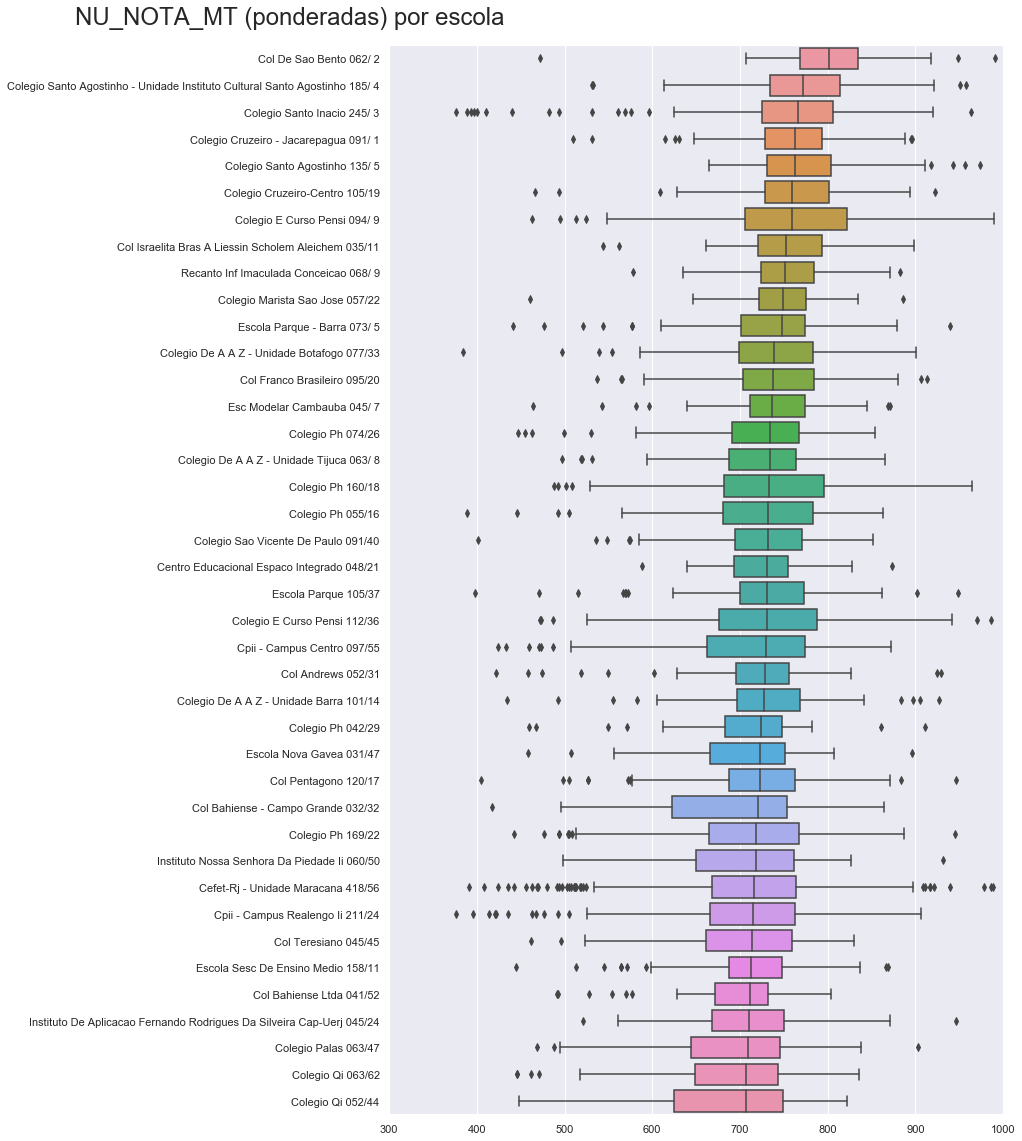

In [98]:
compara_distribuicoes('NU_NOTA_MT');

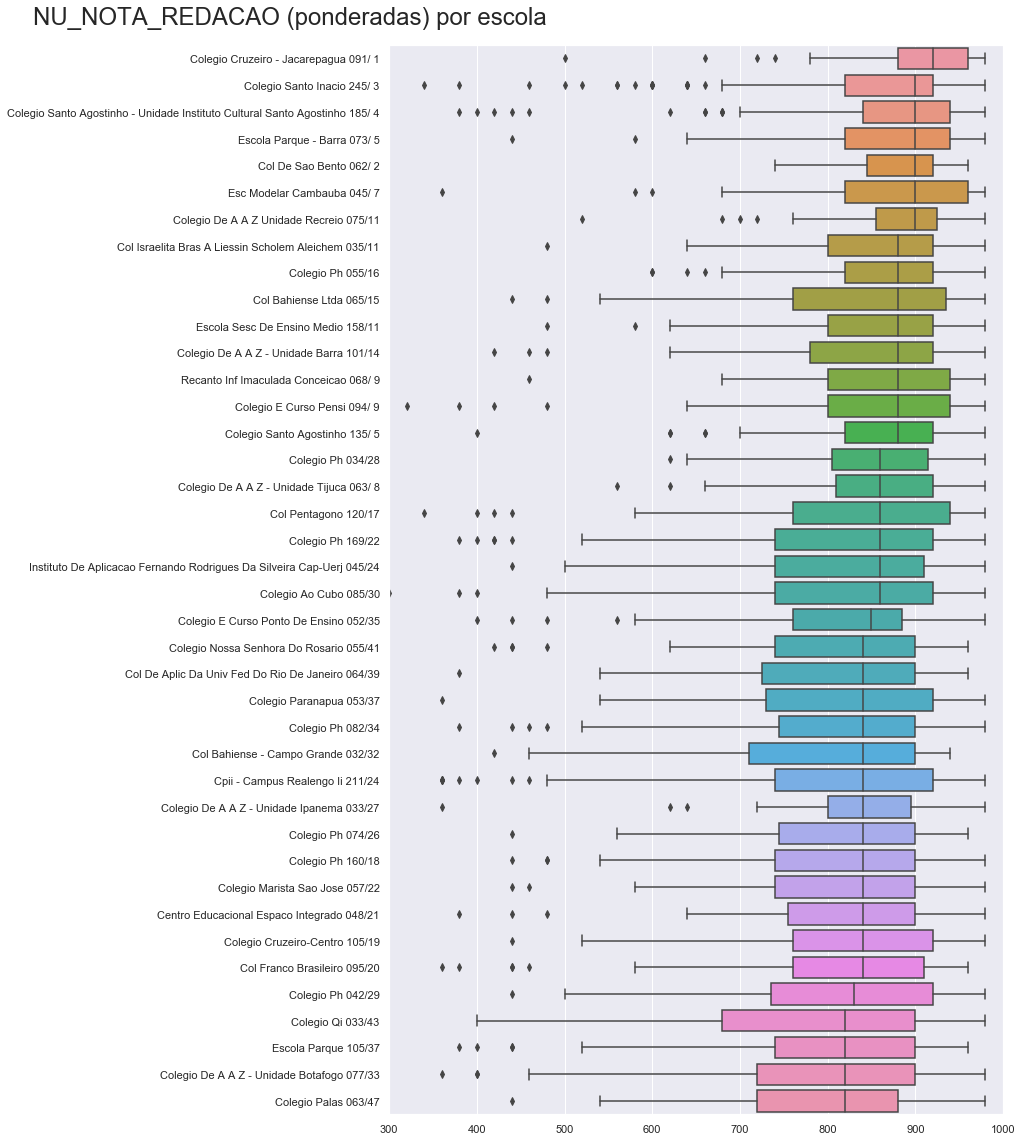

In [99]:
compara_distribuicoes('NU_NOTA_REDACAO');

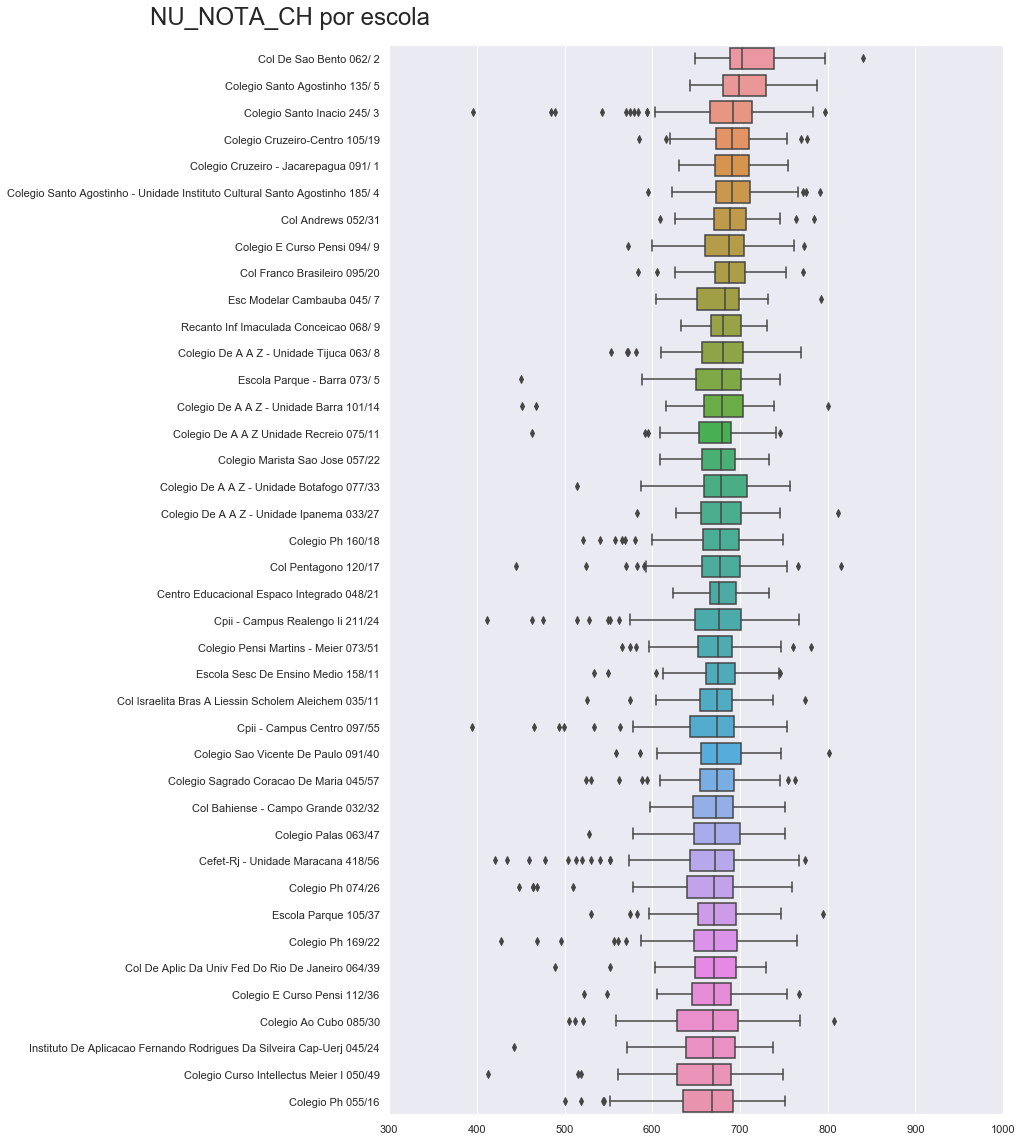

In [106]:
compara_distribuicoes('NU_NOTA_CH');

## Sobrevivência no ensino médio

Quantos dos alunos que começam o ensino médio fazem Enem?

Motivos para diminuir:
- Maus alunos são expulsos
- Maus alunos não acreditam que passarão no Enem
- Vai para universidade fora do Enem (ITAs, PUCs, USP, exterior etc.)

Motivos para aumentar:
- Crise econômica (escolas públicas)
- Bolsa para bons alunos 

### ideias
- comparar com último ano (dá ideia melhor da seleção feita pela escola)
- comparar com quem fez prova (ideia melhor de auto seleção)

In [216]:
etapa_col = 'TP_ETAPA_ENSINO'
primeiro_ano = [25,  30, 35]
# todo: tratar ensinos médios de 4 anos

In [229]:
ano = 2016

import glob
import patoolib
import os.path

def dados_turma(ano, try_rar=True):
    dir_censo = [i for i in glob.glob(f'dados/*{ano}*') if ('censo' in i or 'educacao_basica' in i) and 'zip' not in i]
    assert len(dir_censo) == 1, f'Só pode ter achado um arquivo e achou {len(dir_censo)}'

    arquivo_turmas = glob.glob(f'{dir_censo[0]}/*{ano}*/DADOS/TURMAS.*')
    if not arquivo_turmas:
        arquivo_turmas = glob.glob(f'{dir_censo[0]}/DADOS/TURMAS.*')
    
    result = [i for i in arquivo_turmas if i.lower().endswith('.csv')]
    if not result:
        result = [i for i in arquivo_turmas if i.lower().endswith('.zip')]
        if try_rar and not result:
            rar = [i for i in arquivo_turmas if i.lower().endswith('.rar')]
            if rar:
                patoolib.extract_archive(rar[0], outdir=os.path.dirname(rar[0]))
                result = dados_turma(ano, False)
                
    if result:
        result = result[0]
    else:
        result = None
    return result

for i in range(2007, 2019):
    print(">", dados_turma(i))
#estrutura diretórios bagunçados anets de 2007

> dados\micro_censo_escolar_2007\2007\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2008\2008\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2009\2009\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2010\2010\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2011\2011\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2012\2012\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2013\2013\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2014\2014\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2015\2015\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2016\micro_censo_escolar_2016\DADOS\TURMAS.CSV
> dados\micro_censo_escolar_2017\Microdados_Censo_Escolar_2017\DADOS\TURMAS.zip
> dados\microdados_educacao_basica_2018\microdados_ed_basica_2018\DADOS\TURMAS.zip


In [213]:
df_melhores

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE,rotulo
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,1.0,662.70,691.40,635.00,763.20,920.0,33135371,Colegio Cruzeiro - Jacarepagua 091/ 1
177267,COL DE SAO BENTO,800.5,62,2.0,689.50,702.85,645.70,801.10,900.0,33062633,Col De Sao Bento 062/ 2
177286,COLEGIO SANTO INACIO,789.0,245,3.0,653.30,692.05,628.35,766.70,900.0,33063729,Colegio Santo Inacio 245/ 3
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,788.0,185,4.0,654.40,691.10,637.60,771.80,900.0,33176825,Colegio Santo Agostinho - Unidade Instituto Cu...
188313,ESCOLA PARQUE - BARRA,780.0,73,5.0,615.20,679.80,617.75,747.70,900.0,33148376,Escola Parque - Barra 073/ 5
...,...,...,...,...,...,...,...,...,...,...,...
188256,CE COMPOSITOR MANACEIA JOSE DE ANDRADE,455.0,35,262.0,458.00,552.60,502.60,444.00,410.0,33132887,Ce Compositor Manaceia Jose De Andrade 035/262
189760,CE HERBERT DE SOUZA,454.0,46,263.0,462.30,524.40,480.60,471.50,400.0,33126224,Ce Herbert De Souza 046/263
189279,CE PROFESSOR JOSE DE SOUZA MARQUES,439.0,63,264.0,447.20,556.20,527.50,499.00,360.0,33135193,Ce Professor Jose De Souza Marques 063/264
189673,CIEP 303 AYRTON SENNA DA SILVA,439.0,77,264.0,453.30,556.40,506.00,502.40,380.0,33105103,Ciep 303 Ayrton Senna Da Silva 077/264


In [262]:
#todo: passar isso para ledados

CO_MUN_RIO = 3304557 
def le_turma(ano, escolas, serie):
    print(f"Lendo ano {ano}")
    df_teste = pd.read_csv(
            dados_turma(ano),
            sep="|",
            encoding="latin1",
            nrows=5
        )
    col_etapa = 'TP_ETAPA_ENSINO'
    if col_etapa not in df_teste.columns:
        col_etapa = 'FK_COD_ETAPA_ENSINO'
    col_escola = 'CO_ENTIDADE'    
    if col_escola not in df_teste.columns:
        col_escola = 'PK_COD_ENTIDADE'
        
    df_t = pd.concat((
        df_t[(df_t[col_etapa].isin(serie))]\
        .merge(escolas, left_on=col_escola, right_on='CO_ENTIDADE')
        for df_t in pd.read_csv(
            dados_turma(ano),
            sep="|",
            encoding="latin1",
            chunksize=1000, error_bad_lines=False
        )), 
        sort=True
    )
    df_t['ano'] = ano
    return df_t
    
df_primeiro_ano_turmas = pd.concat(
    (le_turma(i, df_melhores.CO_ENTIDADE, primeiro_ano) for i in range(2013, 2019)), #2007 e 2008, 2009 falharam linhas diferentes
    sort=True)
print(df_primeiro_ano_turmas.shape)
df_primeiro_ano_turmas.head()

Lendo ano 2013


b'Skipping line 138145: expected 80 fields, saw 144\nSkipping line 138155: expected 80 fields, saw 103\n'
b'Skipping line 841050: expected 80 fields, saw 81\nSkipping line 841563: expected 80 fields, saw 124\nSkipping line 841568: expected 80 fields, saw 89\n'
b'Skipping line 1662135: expected 80 fields, saw 121\nSkipping line 1662268: expected 80 fields, saw 143\n'
b'Skipping line 1816998: expected 80 fields, saw 157\n'


Lendo ano 2014


b'Skipping line 46539: expected 79 fields, saw 107\nSkipping line 46544: expected 79 fields, saw 92\n'
b'Skipping line 84628: expected 79 fields, saw 123\n'
b'Skipping line 120722: expected 79 fields, saw 133\n'
b'Skipping line 122737: expected 79 fields, saw 148\n'
b'Skipping line 972960: expected 79 fields, saw 132\n'
b'Skipping line 974361: expected 79 fields, saw 104\nSkipping line 974366: expected 79 fields, saw 103\n'
b'Skipping line 1319226: expected 79 fields, saw 82\n'
b'Skipping line 1320634: expected 79 fields, saw 114\n'


Lendo ano 2015
Lendo ano 2016
Lendo ano 2017
Lendo ano 2018
(11733, 168)


,ANO_CENSO,CO_CURSO_EDUC_PROFISSIONAL,CO_DISTRITO,CO_ENTIDADE,CO_MESORREGIAO,CO_MICRORREGIAO,CO_MUNICIPIO,CO_REGIAO,CO_TIPO_ATIVIDADE_1,CO_TIPO_ATIVIDADE_2,...,TP_DEPENDENCIA,TP_ETAPA_ENSINO,TP_LOCALIZACAO,TP_LOCALIZACAO_DIFERENCIADA,TP_MEDIACAO_DIDATICO_PEDAGO,TP_REGULAMENTACAO,TP_TIPO_TURMA,TX_HR_INICIAL,TX_MI_INICIAL,ano
0,2013.0,NaN,NaN,33531218,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
1,2013.0,NaN,NaN,33531218,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
2,2013.0,NaN,NaN,33531218,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
0,2013.0,NaN,NaN,33148627,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
0,2013.0,NaN,NaN,33110646,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013


In [260]:
le_turma(2008, df_melhores.CO_ENTIDADE, primeiro_ano)

Lendo ano 2008


b'Skipping line 106570: expected 58 fields, saw 72\n'


,ANO_CENSO,CO_ENTIDADE,DESC_CATEGORIA_ESCOLA_PRIVADA,FK_COD_CURSO_PROF,FK_COD_ESTADO,FK_COD_ETAPA_ENSINO,FK_COD_MOD_ENSINO,FK_COD_MUNICIPIO,FK_COD_TIPO_ATIVIDADE_1,FK_COD_TIPO_ATIVIDADE_2,...,ID_QUIMICA,ID_TIPO_CONVENIO_PODER_PUBLICO,ID_VEZ_ATIVIDADE_COMPLEMENTAR,NO_TURMA,NUM_MATRICULAS,NU_DURACAO_TURMA,PK_COD_ENTIDADE,PK_COD_TURMA,SIGLA,ano
0,2008,33075034,NaN,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,NaN,NaN,1202,40.0,300.0,33075034.0,7136606,RJ,2008
1,2008,33075034,NaN,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,NaN,NaN,1203,41.0,300.0,33075034.0,7136608,RJ,2008
0,2008,33065250,NaN,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,NaN,NaN,21A,30.0,340.0,33065250.0,7168803,RJ,2008
1,2008,33065250,NaN,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,NaN,NaN,21C,30.0,340.0,33065250.0,7168709,RJ,2008
2,2008,33065250,NaN,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,NaN,NaN,21B,30.0,340.0,33065250.0,7168932,RJ,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2008,33348200,1.0,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,NaN,NaN,1º ANO,17.0,330.0,33348200.0,8514965,RJ,2008
1,2008,33069778,1.0,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,2.0,NaN,2107,13.0,320.0,33069778.0,8615433,RJ,2008
0,2008,33116903,4.0,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,1.0,NaN,3212,30.0,330.0,33116903.0,6837960,RJ,2008
0,2008,33116903,4.0,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,...,1,1.0,NaN,3211,40.0,330.0,33116903.0,8690773,RJ,2008


In [138]:
'NU_MATRICULAS' in df_ano_um.columns

True

In [263]:
df_ano_um = df_primeiro_ano_turmas[['CO_ENTIDADE',  'ano', 'NU_MATRICULAS']].groupby(['CO_ENTIDADE', 'ano']).sum()
df_ano_um.loc[CO_SAO_VICENTE]

,NU_MATRICULAS
ano,
2013,0.0
2014,0.0
2015,143.0
2016,119.0
2017,121.0
2018,0.0


In [167]:
df_ano_um = pd.concat([df_melhores.set_index('CO_ENTIDADE')[['rotulo', 'num', 'rank']], df_ano_um['NU_MATRICULAS']], axis=1)
df_ano_um.sort_values('rank').head(40)

,rotulo,num,rank,NU_MATRICULAS
CO_ENTIDADE,,,,
33135371,Colegio Cruzeiro - Jacarepagua 091/ 1,91,1.0,102.0
33062633,Col De Sao Bento 062/ 2,62,2.0,74.0
33063729,Colegio Santo Inacio 245/ 3,245,3.0,258.0
33176825,Colegio Santo Agostinho - Unidade Instituto Cu...,185,4.0,NaN
33148376,Escola Parque - Barra 073/ 5,73,5.0,107.0
33065403,Colegio Santo Agostinho 135/ 5,135,5.0,168.0
33085897,Esc Modelar Cambauba 045/ 7,45,7.0,63.0
33173990,Colegio De A A Z - Unidade Tijuca 063/ 8,63,8.0,32.0
33135827,Colegio E Curso Pensi 094/ 9,94,9.0,121.0


In [172]:
df_ano_um.index=df_ano_um.index.astype('category')

In [173]:
df_ano_um['%'] = df_ano_um.num/df_ano_um.NU_MATRICULAS

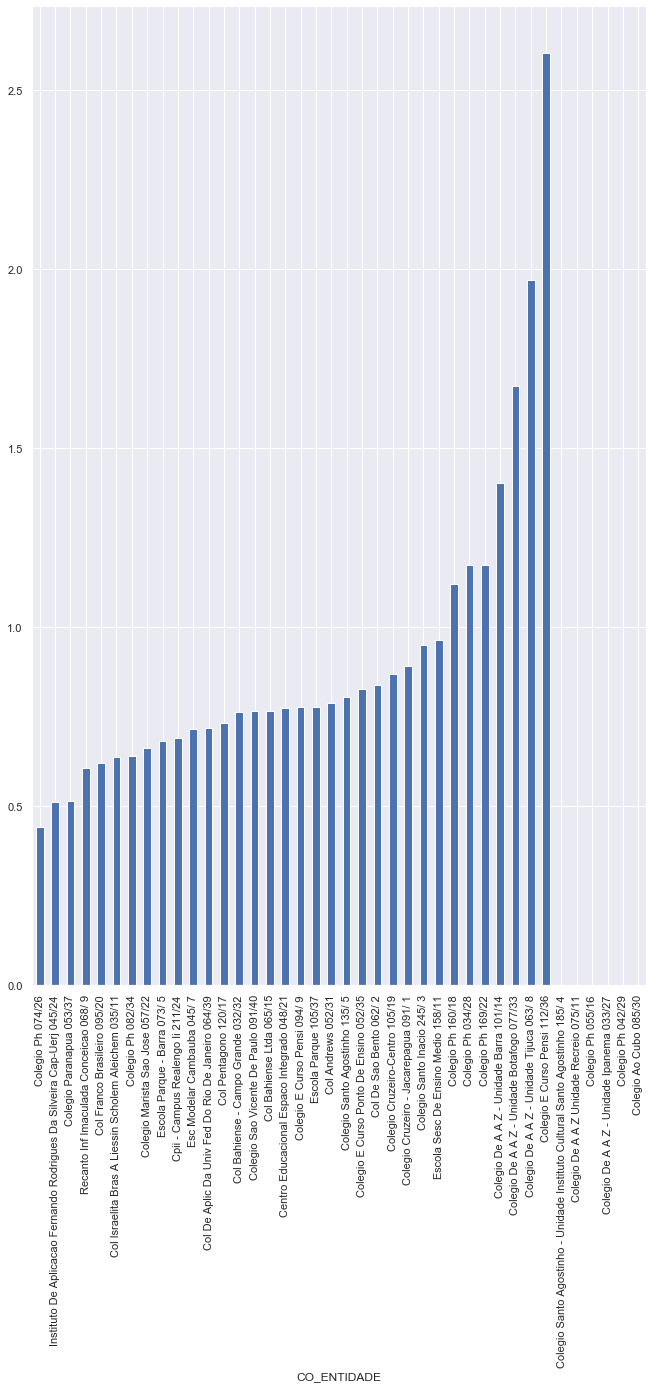

In [191]:
df_ordered = df_ano_um.sort_values('rank').head(NUM_MELHORES).sort_values('%')
ax = df_ordered['%'].plot.bar()
loc, _ = plt.xticks()
plt.xticks(loc, df_ordered.rotulo);

